In [1]:
######################################################################################################
## STEP 1: IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS
######################################################################################################
import os

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image
from src.modules.detection import Detection
from src.modules.canny import Canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path

In [2]:
def process_image(file_path):
    try:
        # Etapa 1: Leitura da imagem
        img = Image(file_path)
        img.reading_image()

        # Etapa 2: Detecção de características
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        # Etapa 3: Detecção de bordas
        canny = Canny(detection.mouth, detection.nose, detection.left_eye, detection.right_eye)
        canny.compute_all_edges()

        # # Etapa 4: Criação das matrizes de adjacência
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()

        # Etapa 6: Cálculo da árvore geradora mínima
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()

        # Etapa 7: Construção da árvore e poda
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        

        print(f"Processado: {file_path}")
        return img, detection, canny, adjacency_matrix, components_results, mst, tree

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './image'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('pedro.jpg'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))

Processado: ./image\pedro.jpg


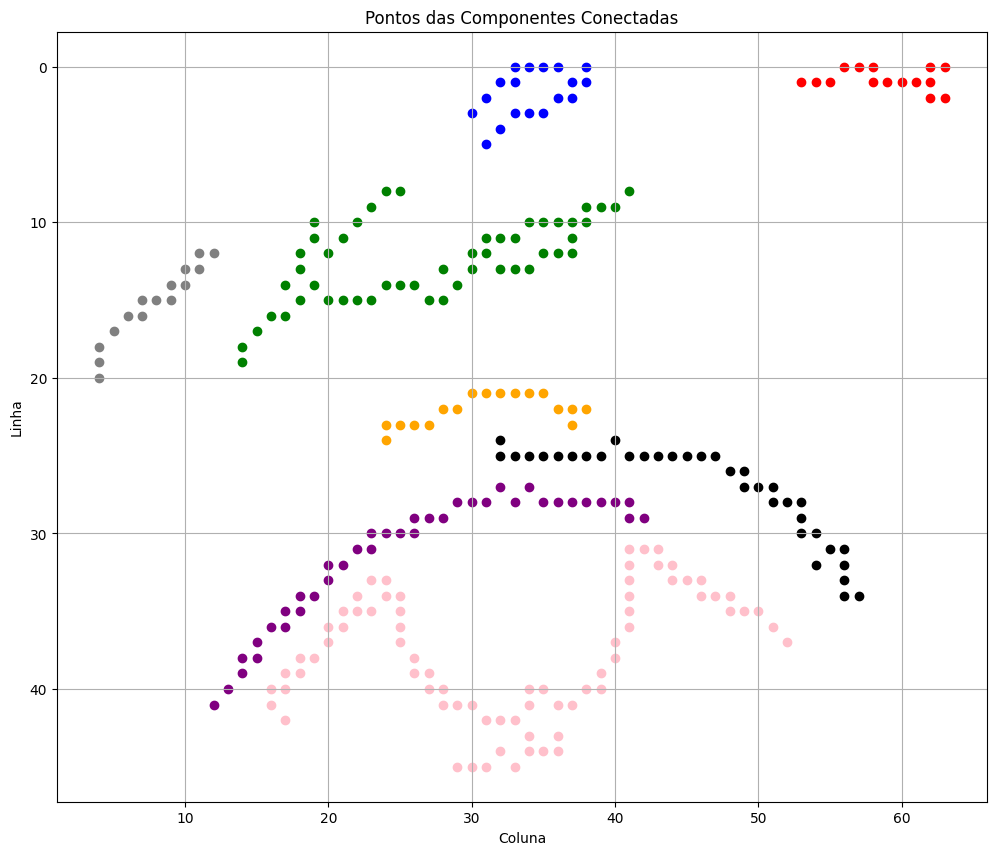

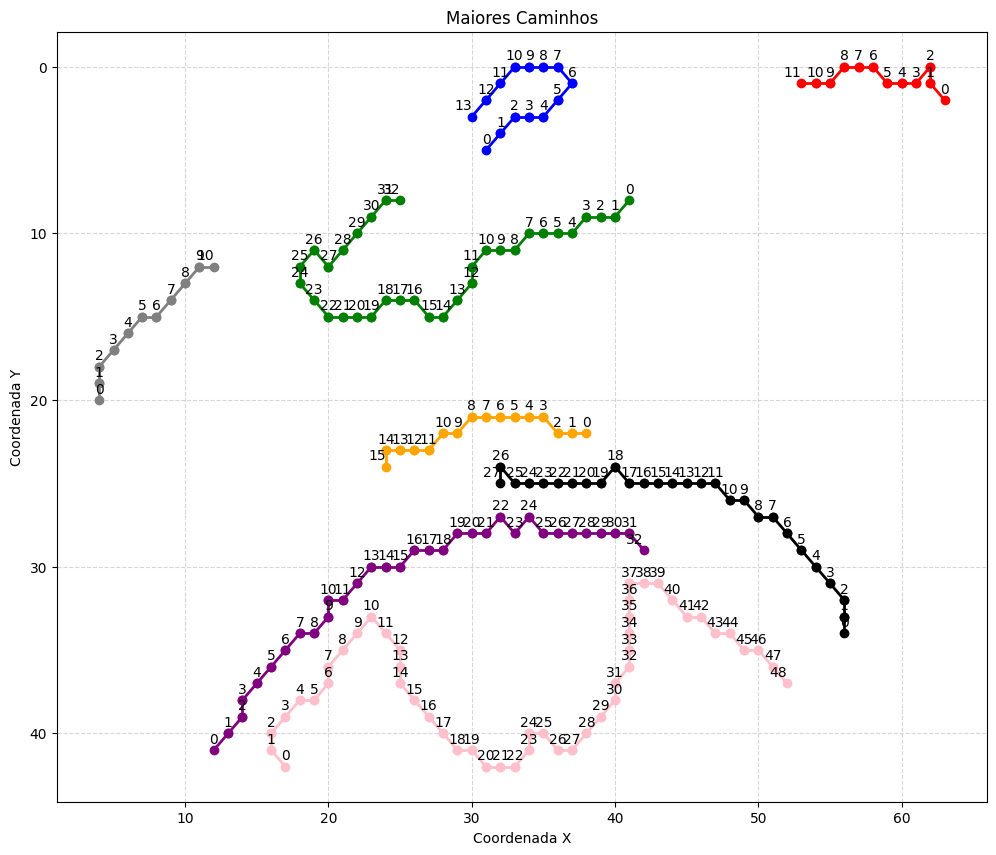

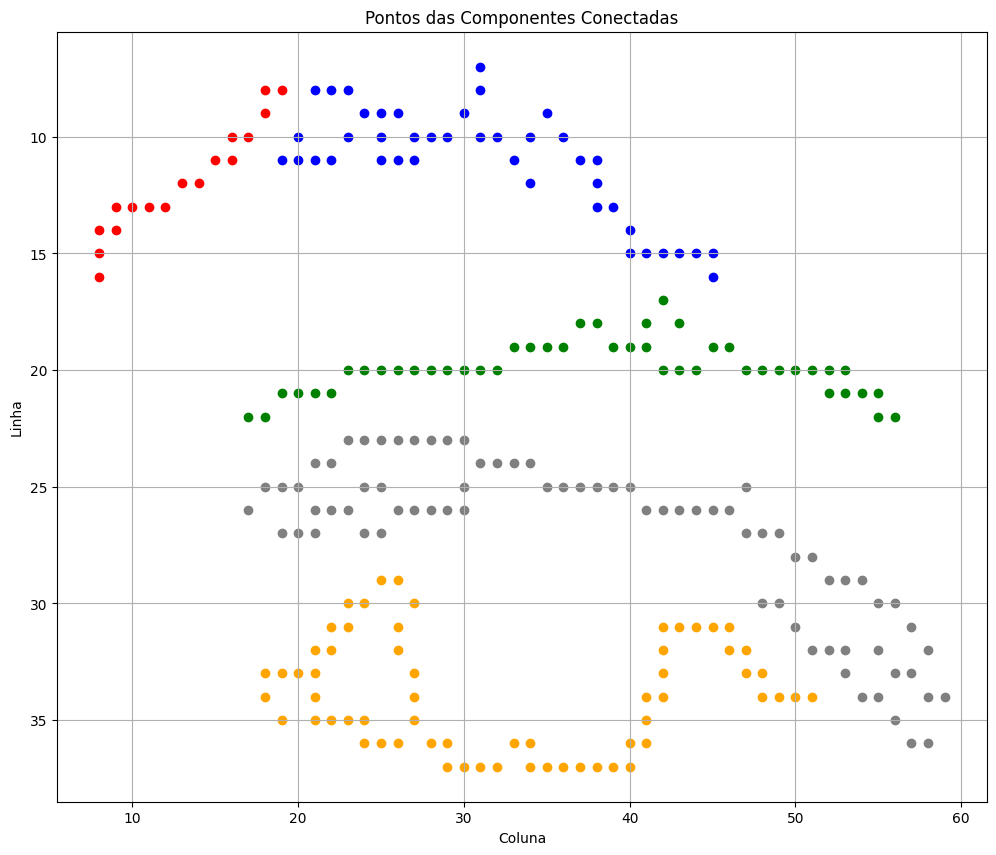

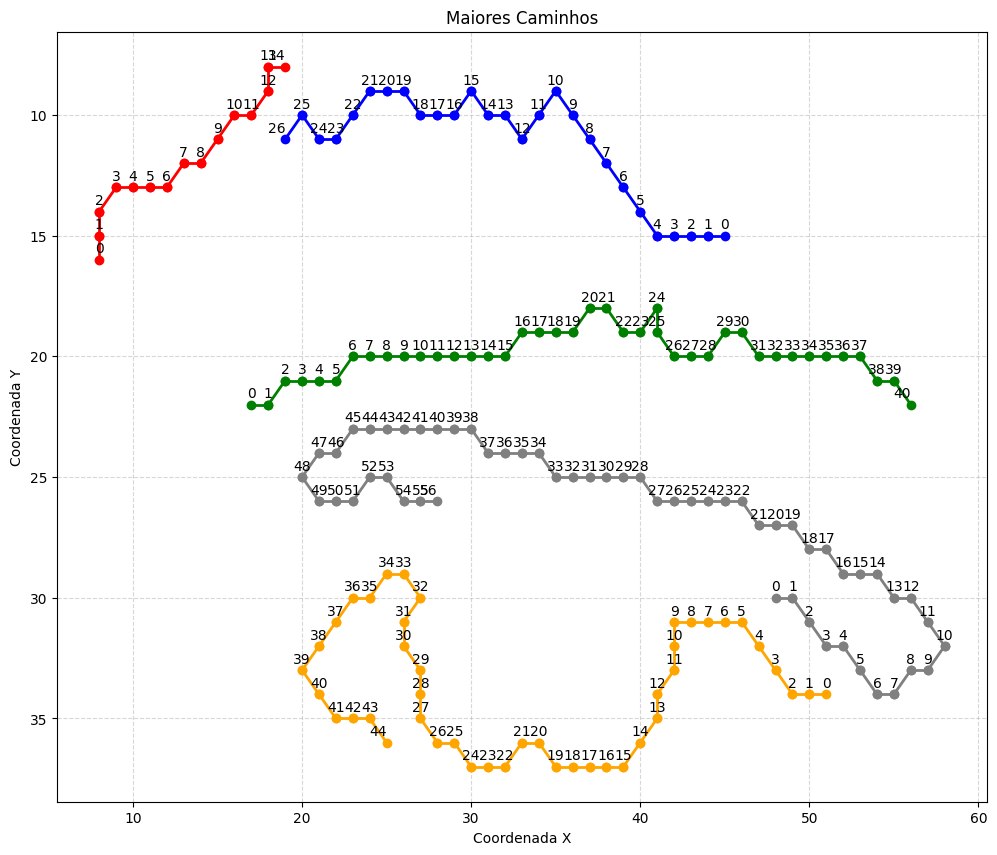

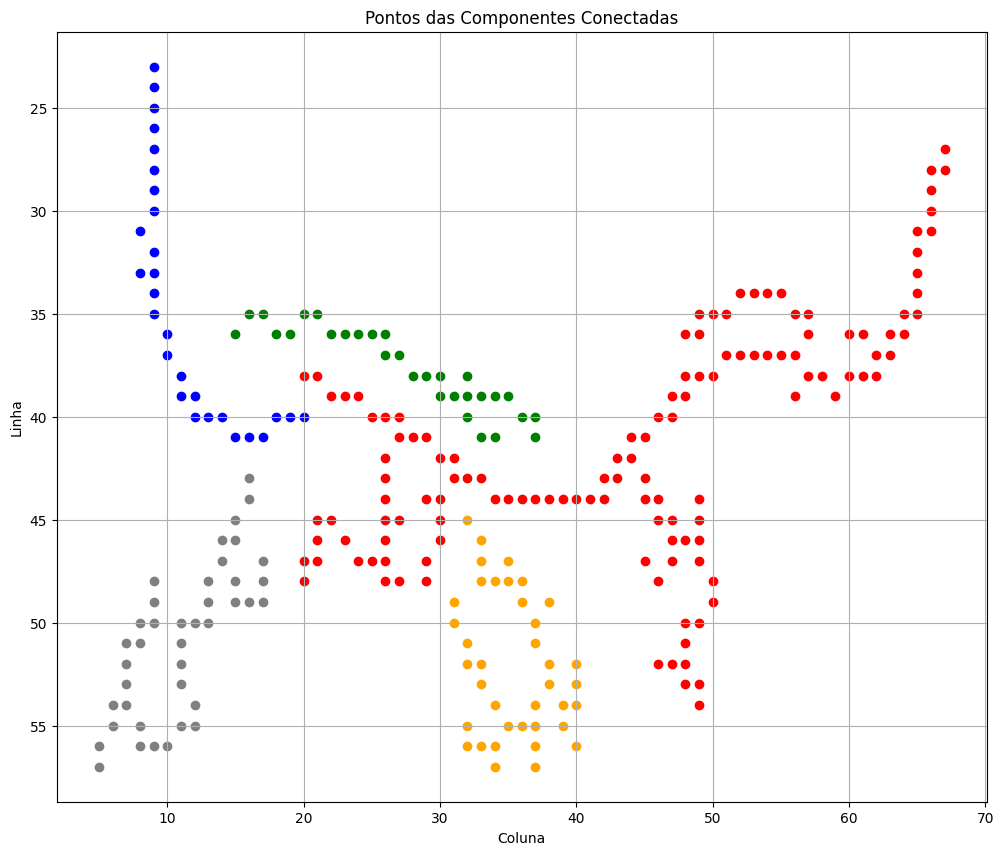

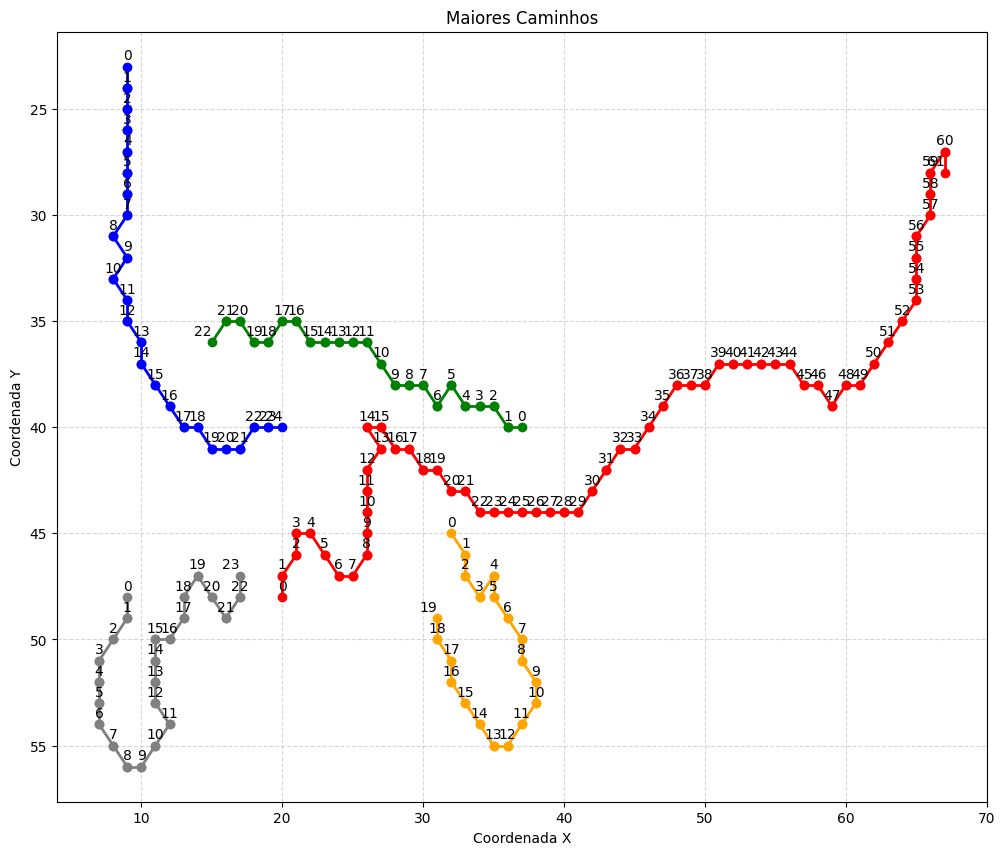

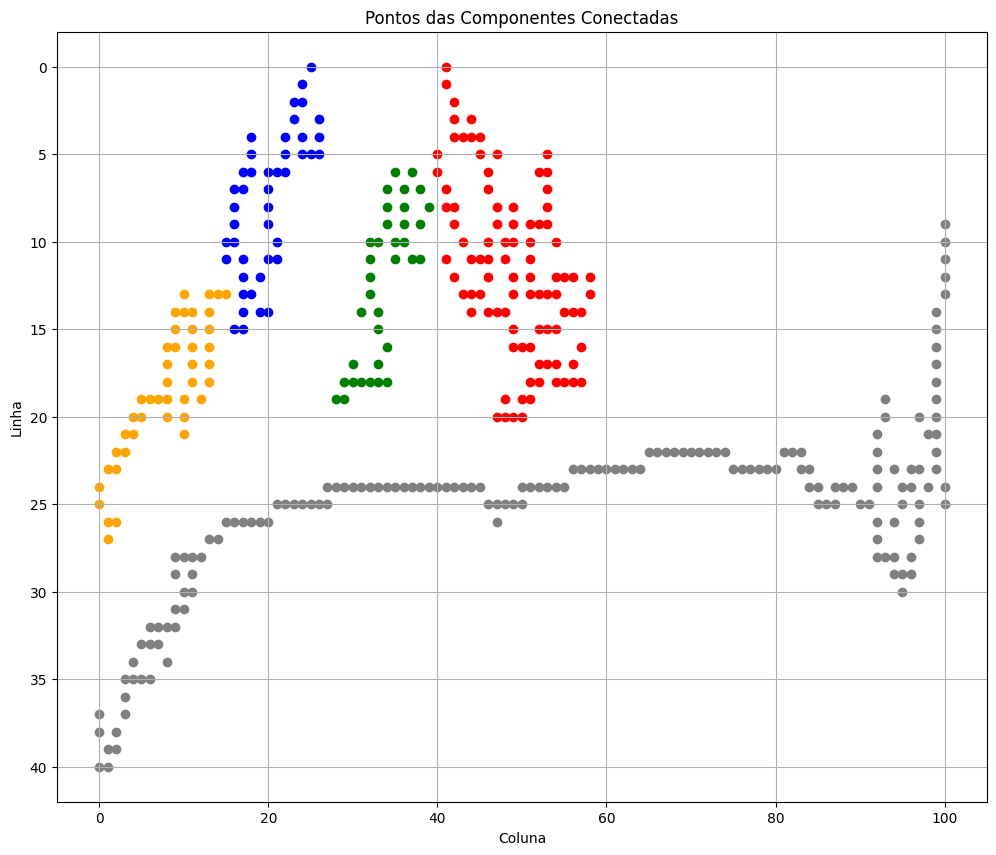

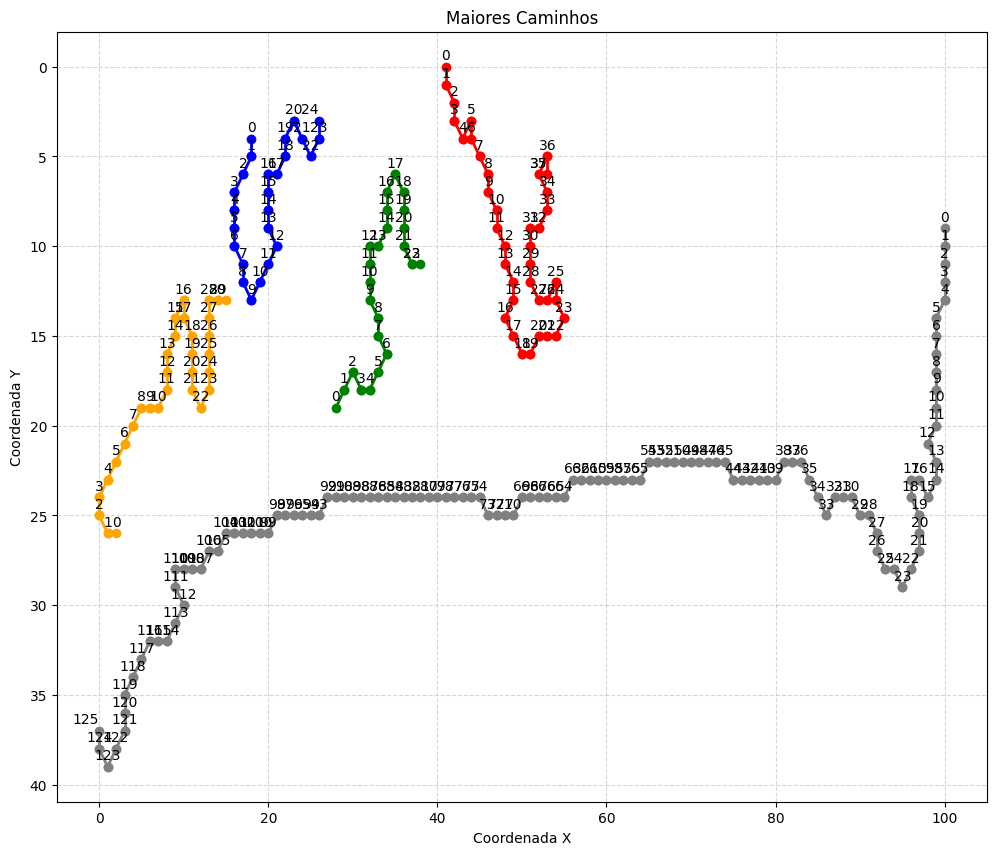

In [3]:
highlight_components(results[0][2].left_eye_dict, results[0][4].dic_main_left_eye_cc)
plot_logest_path(results[0][2].left_eye_dict, results[0][6].longest_path_left_eye, results[0][5].nodes_left_eye)


highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye)


highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)


highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc)
plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth)

Dicionário de labels: {0: [0, 1, 2, 3, 4], 1: [5], 2: [6, 7, 8, 9], 3: [10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 26], 4: [14, 17], 5: [19, 22, 25, 28, 30, 35, 38, 40, 43, 48, 52, 53, 58, 66, 80, 99, 114, 135, 136, 152, 153, 154, 155, 156, 157, 168, 169, 170], 6: [24, 27], 7: [29, 31, 32, 33], 8: [34, 36, 37, 39, 42, 46, 47, 51, 57, 61, 62, 63, 64, 65, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 148, 149, 150, 151, 158, 159, 160, 165, 166, 171, 172, 173, 180, 181, 183, 184, 185, 186, 187, 195, 196, 197, 198, 199, 200, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 229, 230, 231, 232, 233, 235, 236, 237, 246, 247, 248, 249, 252, 253, 254, 262, 263, 264, 265, 266, 267, 271, 272, 273, 284, 285, 286, 287, 293, 294, 309, 330, 331, 348, 371, 372, 373, 392, 393, 418], 9: [41, 44, 45, 50, 56, 60, 72, 89, 90, 91, 102, 103, 104, 121, 122, 123, 124], 

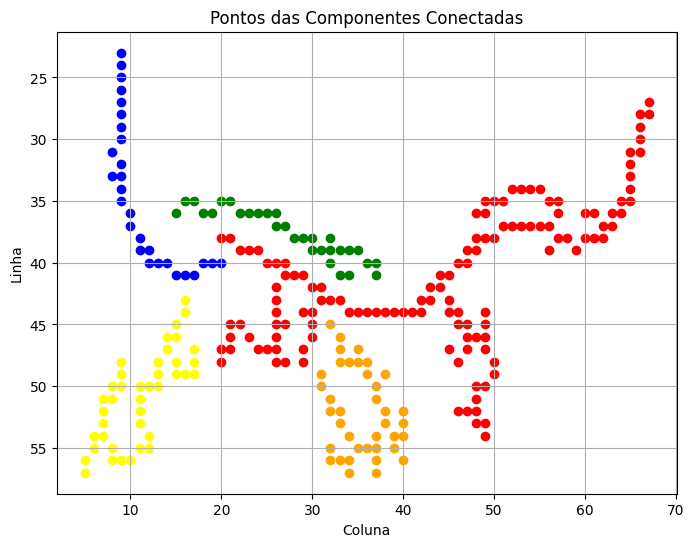

In [9]:

if __name__ == "__main__": 
    all_mAdjNose, mainCoord, image_path = main()
    dicMainComponents, connectedComponentLabels= main_connected_components(all_mAdjNose)
    highlight_components(mainCoord, dicMainComponents)


In [10]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
X = csr_matrix([[0, 1, 0, 1, 0],
                [0, 0, 1, 1, 0],
                [0, 0, 0, 1, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 0, 0, 1]])
Tcsr = minimum_spanning_tree(X)
Tcsr.toarray().astype(int)

array([[0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
class MinimunSpanningTree:
    def __init__(self,dic_main_nose_cc, dic_main_mouth_cc, dic_main_left_eye_cc, dic_main_right_eye_cc):
        self.dic_main_nose_cc = dic_main_nose_cc
        self.dic_main_mouth_cc = dic_main_mouth_cc
        self.dic_main_left_eye_cc = dic_main_left_eye_cc
        self.dic_main_right_eye_cc = dic_main_right_eye_cc

    def minimum_spanning_tree(self):
        for 


In [11]:
from scipy.sparse.csgraph import minimum_spanning_tree

class PrincipaisConexos():
    def __init__(self, idx, nodes, min_tree = None, raiz = None, altura = None, caminho_altura_maxima = None, tamanho_caminho_maximo = None, caminho_maximo = None):
        self.idx = idx
        self.nodes = nodes
        self.min_tree = min_tree
        self.raiz = raiz
        self.altura = altura
        self.caminho_altura_maxima = caminho_altura_maxima
        self.tamanho_caminho_maximo = tamanho_caminho_maximo
        self.caminho_maximo = caminho_maximo
mainConnected = []
for key, values in dicMainComponents.items():
    mainConnected.append(PrincipaisConexos(key, values))


for i in range(len(mainConnected)):
    componente = mainConnected[i]
    submatriz_adj = all_mAdjNose[0][np.ix_(mainConnected[i].nodes, mainConnected[i].nodes)]
    min_tree = minimum_spanning_tree(submatriz_adj).toarray().astype(int)
    min_tree += min_tree.T
    mainConnected[i].min_tree = min_tree


class No():
    def __init__(self, idx, filhos=None):
        # Inicializa o nó com o índice 'idx' e uma lista de filhos. Se 'filhos' não for passado,
        # uma nova lista vazia é criada para evitar que uma mesma lista seja compartilhada entre instâncias.
        self.idx = idx
        self.filhos = filhos if filhos is not None else []
        
def constroi_arvore(arvore): # Alterando o argumento para 'arvore' (geral) ao invés de usar 'arvore_3' (específico já criado)
    abertos = []  
    n_nos = len(arvore) 
    if n_nos > 0: 
        raiz = No(0) 
        abertos.append(raiz) 

    proximo_no = 0 
    while proximo_no < len(abertos): 
        no = abertos[proximo_no] 
        proximo_no += 1
        for j in range(n_nos): 
            if arvore[no.idx, j] == 1:
                ja_visitou = False 
                for i in range(proximo_no):
                    if abertos[i].idx == j:
                        ja_visitou = True 
                        break
                if not ja_visitou:
                    filho = No(j) 
                    abertos.append(filho)
                    no.filhos.append(filho)
    return raiz
for i in range(len(mainConnected)):
    mainConnected[i].raiz = constroi_arvore(mainConnected[i].min_tree)
def podando_arvore(raiz):
    if len(raiz.filhos) == 0: # Condição base (nó folha)
        return 1, [raiz.idx], 1, [raiz.idx] # Se o nó não tiver filhos, sua altura é 0 e seu caminho é ele mesmo
    else: # Caso recursivo (nó com filhos)
        for filho in raiz.filhos: 
            # print('filho:', filho.idx)
            filho.altura, filho.caminho_altura_maxima, filho.tamanho_caminho_maximo, filho.caminho_maximo = podando_arvore(filho) # Para cada filho do nó atual, a função é chamada recursivamente, retornando a altura e o caminho para cada um dos filhos.

        if len(raiz.filhos) == 1:
            if raiz.filhos[0].altura + 1 > raiz.filhos[0].tamanho_caminho_maximo:
                tamanho_caminho_maximo = raiz.filhos[0].altura + 1
                caminho_maximo = [raiz.idx] + raiz.filhos[0].caminho_altura_maxima
            else:
                tamanho_caminho_maximo = raiz.filhos[0].tamanho_caminho_maximo
                caminho_maximo = raiz.filhos[0].caminho_maximo
        else:
            raiz.filhos.sort(key=lambda x: x.altura, reverse=True)
            tamanho_caminho_maximo = raiz.filhos[0].altura + raiz.filhos[1].altura + 1
            uma_parte_do_caminho = raiz.filhos[0].caminho_altura_maxima.copy()
            uma_parte_do_caminho.reverse()
            caminho_maximo = uma_parte_do_caminho + [raiz.idx] + raiz.filhos[1].caminho_altura_maxima
            for filho in raiz.filhos: 
                if filho.tamanho_caminho_maximo > tamanho_caminho_maximo:
                    tamanho_caminho_maximo = filho.tamanho_caminho_maximo 
                    caminho_maximo = filho.caminho_maximo

        no_altura_maxima = raiz.filhos[0] # max(raiz.filhos, key=lambda x: x.altura) # Entre todos os filhos, o código encontra aquele que tem a maior altura (o caminho mais longo até uma folha).

        return no_altura_maxima.altura + 1, [raiz.idx] + no_altura_maxima.caminho_altura_maxima, tamanho_caminho_maximo, caminho_maximo # A altura retornada é incrementada em 1, pois estamos subindo um nível na árvore, e o caminho máximo é atualizado para incluir o nó atual (raiz.idx) na frente da lista.


def plot_caminhos(mainCoord, maiores_caminhos, idx_desejado):
    plt.figure(figsize=(8, 6))

    # Plotar todos os nós como pontos
    coords = np.array(mainCoord)
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'black', 'purple', 'pink', 'brown', 'gray']
    cor=0
    anotacao = {}
    # plt.scatter(coords[:, 1], coords[:, 0], s=50, color='black', label='Nó')

    if set(idx_desejado).issubset(set([connected.idx for connected in mainConnected])):
        i = 0

        for connected in mainConnected:
            if connected.idx in idx_desejado:
            # Verificar se o idx_desejado está no dicionário
            # if idx_desejado in maiores_caminhos:
                caminho = maiores_caminhos[connected.idx]
                # Iterar por pares de nós no caminho
                anotacao_coordendas = []
                label = []
                for i in range(len(caminho) - 1):
                    node_idx = connected.nodes[caminho[i]]
                    coord_inicial = coords[node_idx]    # Coordenada do nó inicial
                    next_node_idx = connected.nodes[caminho[i+1]]
                    coord_final = coords[next_node_idx]  # Coordenada do nó seguinte
                    
                    # Plotar a linha conectando os nós do componente desejado
                    plt.plot([coord_inicial[1], coord_final[1]], [coord_inicial[0], coord_final[0]], 'o-', label=f'Componente {connected.idx}' if i == 0 else "", linewidth=2, color=colors[cor])
                    
                    # Anotar o número do nó no gráfico
                    plt.annotate(f'{i}', (coord_inicial[1], coord_inicial[0]), textcoords="offset points", xytext=(0,5), ha='center', color='black')
                    anotacao_coordendas.append((coord_inicial[1], coord_inicial[0]))
                    label.append(i)

                anotacao[connected.idx] = anotacao_coordendas
                cor +=1
                
                # Anotar o último nó do caminho
                last_node_idx = connected.nodes[caminho[-1]]
                plt.annotate(f'{len(caminho) - 1}', (coords[last_node_idx][1], coords[last_node_idx][0]), textcoords="offset points", xytext=(0,5), ha='center', color='black')
                anotacao[connected.idx].append((coords[last_node_idx][1], coords[last_node_idx][0]))
    else:
        print(f"Componentes não encontrados: {set(idx_desejado) - set([connected.idx for connected in mainConnected])}")


    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title(f'Maiores Caminhos - Componente {idx_desejado}')
    # plt.legend(loc='best')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
    plt.show()

    return anotacao

In [12]:
maiores_caminhos = {}

for i in range(len(mainConnected)):
     print(podando_arvore(mainConnected[i].raiz)[0])
     print(podando_arvore(mainConnected[i].raiz)[1])
     print(podando_arvore(mainConnected[i].raiz)[2])
     print(podando_arvore(mainConnected[i].raiz)[3])
     maiores_caminhos[mainConnected[i].idx] = podando_arvore(mainConnected[i].raiz)[3]
     print('-----------------')

25
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
25
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
-----------------
61
[0, 1, 3, 4, 5, 7, 8, 13, 19, 26, 34, 44, 43, 52, 42, 41, 33, 32, 31, 30, 29, 28, 40, 39, 38, 49, 56, 62, 61, 66, 72, 85, 84, 83, 82, 81, 80, 79, 78, 71, 70, 65, 64, 60, 59, 55, 54, 58, 63, 68, 75, 92, 100, 108, 107, 99, 91, 90, 98, 105, 114]
62
[114, 105, 98, 90, 91, 99, 107, 108, 100, 92, 75, 68, 63, 58, 54, 55, 59, 60, 64, 65, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 72, 66, 61, 62, 56, 49, 38, 39, 40, 28, 29, 30, 31, 32, 33, 41, 42, 52, 43, 44, 34, 26, 19, 13, 8, 7, 5, 4, 3, 1, 0, 2]
-----------------
22
[0, 1, 5, 6, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 17, 21, 22, 23, 25, 26]
23
[26, 25, 23, 22, 21, 17, 19, 16, 15, 14, 13, 11, 10, 9, 8, 7, 3, 2, 6, 5, 1, 0, 4]
-----------------
24
[0, 1, 2, 3, 5, 8, 12, 19, 18, 23, 25, 27, 30, 33, 38, 37, 32, 29, 26, 24, 21, 16, 11, 7]
2

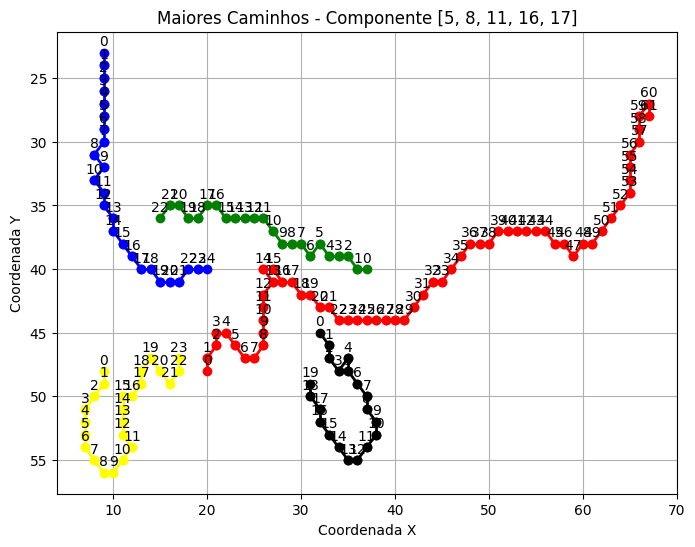

In [13]:
anotacao = plot_caminhos(mainCoord, maiores_caminhos, idx_desejado=[connected.idx for connected in mainConnected])

In [14]:
novo_maiores_caminhos = {}
for key, value in maiores_caminhos.items():
    print('Componente:', key)
    print('Caminho:', value)
    print('Tamanho do caminho:', len(value))

    # Garante que o primeiro e o último elementos estejam na amostra
    primeiro_elemento = value[0]
    ultimo_elemento = value[-1]

    # Exclui o segundo e o penúltimo elementos da seleção, além do primeiro e do último
    intermediarios = value[2:-2]  # Exclui o primeiro, segundo, penúltimo e último

    # Calcula quantos elementos aleatórios ainda precisam ser adicionados
    tamanho_amostra = int(len(value) * 0.4) - 2 # -2 para o primeiro e o último já selecionados

    amostra_intermediarios = []
    indices_usados = set()

    while len(amostra_intermediarios) < tamanho_amostra:
        indice = random.choice(range(len(intermediarios)))
        # Verifica se o índice ou o consecutivo estão usados
        if indice not in indices_usados and (indice - 1) not in indices_usados and (indice + 1) not in indices_usados:
            amostra_intermediarios.append(intermediarios[indice])
            indices_usados.add(indice)

    # Ordena para manter a ordem original da lista
    amostra_intermediarios.sort(key=value.index)
    
    # Junta tudo mantendo a ordem original: primeiro, intermediários em ordem, último
    amostra = [primeiro_elemento] + amostra_intermediarios + [ultimo_elemento]
    novo_maiores_caminhos[key] = amostra
    print('Amostra:', amostra)
    print('-----------------')

Componente: 5
Caminho: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
Tamanho do caminho: 25
Amostra: [0, 4, 6, 9, 14, 16, 20, 26, 22, 24]
-----------------
Componente: 8
Caminho: [114, 105, 98, 90, 91, 99, 107, 108, 100, 92, 75, 68, 63, 58, 54, 55, 59, 60, 64, 65, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 72, 66, 61, 62, 56, 49, 38, 39, 40, 28, 29, 30, 31, 32, 33, 41, 42, 52, 43, 44, 34, 26, 19, 13, 8, 7, 5, 4, 3, 1, 0, 2]
Tamanho do caminho: 62
Amostra: [114, 98, 99, 92, 68, 54, 65, 71, 80, 83, 72, 61, 49, 39, 29, 31, 41, 44, 26, 13, 7, 4, 1, 2]
-----------------
Componente: 11
Caminho: [26, 25, 23, 22, 21, 17, 19, 16, 15, 14, 13, 11, 10, 9, 8, 7, 3, 2, 6, 5, 1, 0, 4]
Tamanho do caminho: 23
Amostra: [26, 17, 16, 14, 10, 8, 2, 5, 4]
-----------------
Componente: 16
Caminho: [7, 11, 16, 21, 24, 26, 29, 32, 37, 38, 33, 30, 27, 25, 23, 18, 19, 12, 8, 5, 9, 14, 10, 6]
Tamanho do caminho: 24
Amostra: [7, 26, 32, 33, 27, 19, 8, 14, 6]
--------------

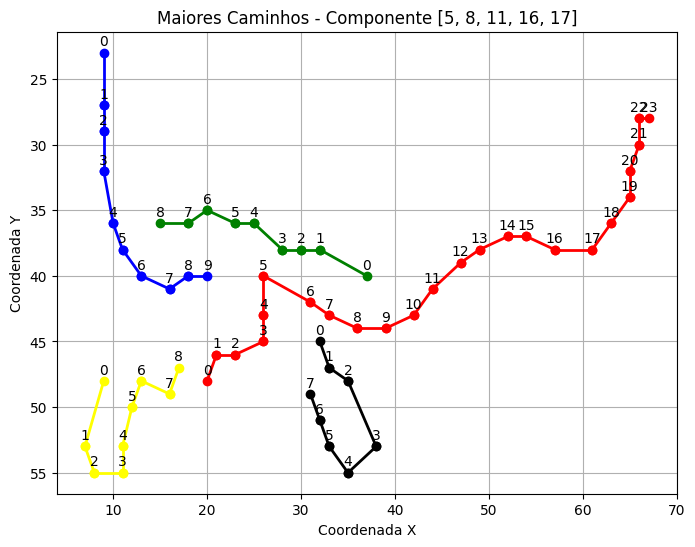

In [15]:
anotacao_novo_maiores_caminhos = plot_caminhos(mainCoord, novo_maiores_caminhos, idx_desejado=[connected.idx for connected in mainConnected])

In [16]:
anotacao_novo_maiores_caminhos

{5: [(9, 23),
  (9, 27),
  (9, 29),
  (9, 32),
  (10, 36),
  (11, 38),
  (13, 40),
  (16, 41),
  (18, 40),
  (20, 40)],
 8: [(20, 48),
  (21, 46),
  (23, 46),
  (26, 45),
  (26, 43),
  (26, 40),
  (31, 42),
  (33, 43),
  (36, 44),
  (39, 44),
  (42, 43),
  (44, 41),
  (47, 39),
  (49, 38),
  (52, 37),
  (54, 37),
  (57, 38),
  (61, 38),
  (63, 36),
  (65, 34),
  (65, 32),
  (66, 30),
  (66, 28),
  (67, 28)],
 11: [(37, 40),
  (32, 38),
  (30, 38),
  (28, 38),
  (25, 36),
  (23, 36),
  (20, 35),
  (18, 36),
  (15, 36)],
 16: [(9, 48),
  (7, 53),
  (8, 55),
  (11, 55),
  (11, 53),
  (12, 50),
  (13, 48),
  (16, 49),
  (17, 47)],
 17: [(32, 45),
  (33, 47),
  (35, 48),
  (38, 53),
  (35, 55),
  (33, 53),
  (32, 51),
  (31, 49)]}

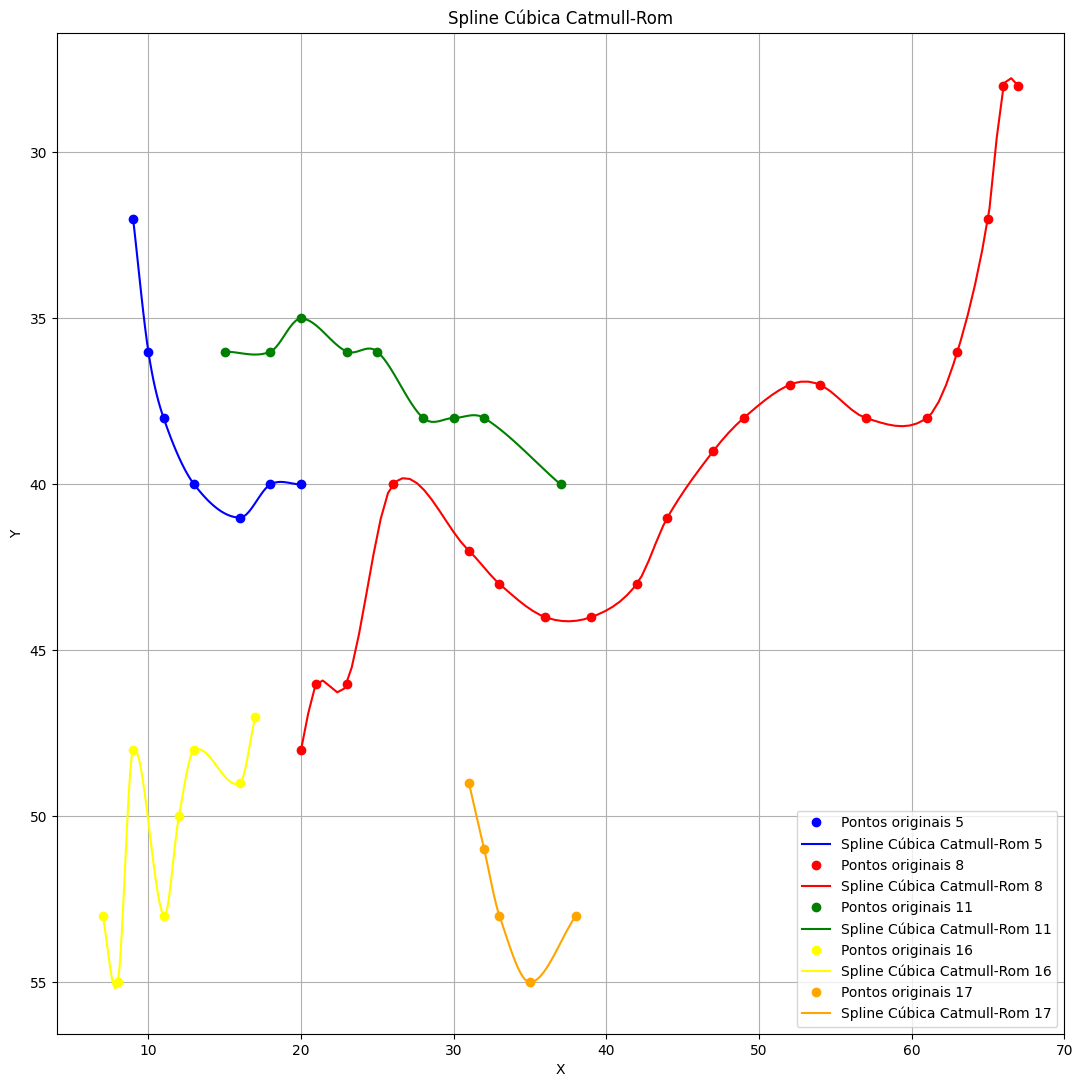

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

# Definindo as cores para cada spline
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']

# Criando uma nova figura
plt.figure(figsize=(13, 13))

for idx, (key, value) in enumerate(anotacao_novo_maiores_caminhos.items()):
    # Dados
    data = anotacao_novo_maiores_caminhos[key]

    # Extraindo as coordenadas x e y
    coordenadas = np.array(data)
    x = coordenadas[:, 0]
    y = coordenadas[:, 1]

    # Remover duplicatas e manter a ordem
    unique_coords = {k: v for k, v in zip(x, y)}
    unique_x = np.array(list(unique_coords.keys()))
    unique_y = np.array(list(unique_coords.values()))

    # Reorganizando os pontos para um x crescente
    indices = np.argsort(unique_x)
    x_sorted = unique_x[indices]
    y_sorted = unique_y[indices]

    # Criando a spline cúbica Catmull-Rom
    n = len(x_sorted)

    # Inicializando a lista de tangentes
    tangents = np.zeros(n)

    # Calculando as tangentes
    for i in range(1, n - 1):
        tangents[i] = (y_sorted[i + 1] - y_sorted[i - 1]) / (x_sorted[i + 1] - x_sorted[i - 1])

    # Definindo as tangentes para o primeiro e o último ponto
    tangents[0] = (y_sorted[1] - y_sorted[0]) / (x_sorted[1] - x_sorted[0])
    tangents[-1] = (y_sorted[-1] - y_sorted[-2]) / (x_sorted[-1] - x_sorted[-2])

    # Usando a spline de Hermite
    cs = CubicHermiteSpline(x_sorted, y_sorted, tangents)

    # Criando pontos para a linha da spline
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), 100)
    y_new = cs(x_new)

    # Plotando os pontos e a spline com a cor correspondente
    plt.plot(x_sorted, y_sorted, 'o', label=f'Pontos originais {key}', color=colors[idx % len(colors)])
    plt.plot(x_new, y_new, '-', label=f'Spline Cúbica Catmull-Rom {key}', color=colors[idx % len(colors)])

# Configurações do gráfico
plt.title('Spline Cúbica Catmull-Rom')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
plt.show()


In [18]:
anotacao_novo_maiores_caminhos

{5: [(9, 23),
  (9, 27),
  (9, 29),
  (9, 32),
  (10, 36),
  (11, 38),
  (13, 40),
  (16, 41),
  (18, 40),
  (20, 40)],
 8: [(20, 48),
  (21, 46),
  (23, 46),
  (26, 45),
  (26, 43),
  (26, 40),
  (31, 42),
  (33, 43),
  (36, 44),
  (39, 44),
  (42, 43),
  (44, 41),
  (47, 39),
  (49, 38),
  (52, 37),
  (54, 37),
  (57, 38),
  (61, 38),
  (63, 36),
  (65, 34),
  (65, 32),
  (66, 30),
  (66, 28),
  (67, 28)],
 11: [(37, 40),
  (32, 38),
  (30, 38),
  (28, 38),
  (25, 36),
  (23, 36),
  (20, 35),
  (18, 36),
  (15, 36)],
 16: [(9, 48),
  (7, 53),
  (8, 55),
  (11, 55),
  (11, 53),
  (12, 50),
  (13, 48),
  (16, 49),
  (17, 47)],
 17: [(32, 45),
  (33, 47),
  (35, 48),
  (38, 53),
  (35, 55),
  (33, 53),
  (32, 51),
  (31, 49)]}

In [19]:
import numpy as np

def catmull_rom_t(control_x, control_y, T):

    def q(t): # Função para calcular a posição da spline cúbica Catmull-Rom em um ponto t (0 <= t <= 1) 
        # Matriz de coeficientes para calcular a posição da spline cúbica Catmull-Rom em um ponto t (0 <= t <= 1)
        # o vetor de controle é uma matriz 4x2 onde cada linha é um ponto de controle
        # o vetor de coeficientes é uma matriz 4x4 onde cada linha é um conjunto de coeficientes para um ponto de controle
        return 1/2 * np.array([t**3, t**2, t, 1]) @ np.array([[-1/T, (4*T-1)/T, (-4*T +1)/T, 1/T], 
                                                              [2/T, (-6*T+1)/T, (6*T-2)/T, -1/T], 
                                                              [-1/T, 0, 1/T, 0], 
                                                              [0, 2, 0, 0]]) @ np.array([control_x, control_y]).T
    return q

# multiplicacao de matrizes:
# np.array([t**3, t**2, t, 1])  dimensao 1x4
# np.array([[-1/T, (4*T-1)/T, (-4*T +) dimension 4x4
# np.array([control_x, control_y]).T dimensao 4x2

In [20]:
print(np.array([4, 3, 2, 1]))

[4 3 2 1]


In [21]:
coordenadas = anotacao_novo_maiores_caminhos[5] # Coordenadas do componente 5
control_x = [coord[0] for coord in coordenadas] # Coordenadas x dos pontos de controle
control_y = [coord[1] for coord in coordenadas] # Coordenadas y dos pontos de controle

# Adicionando pontos fantasmas
control_x.insert(0, control_x[0] - 0.1) # Adicionando um ponto à esquerda
control_x.append(control_x[-1] + 0.1) # Adicionando um ponto à direita
control_y.insert(0, control_y[0] - 0.1) # Adicionando um ponto acima
control_y.append(control_y[-1] + 0.1)# Adicionando um ponto abaixo

T = 1 # Parâmetro T (tensão) para a spline cúbica Catmull-Rom
t = np.arange(0, 1.1, 0.1) # Pontos t para interpolação
N = len(control_x) # Número de pontos de controle

# N-3 por que estamos usando 4 pontos de controle para cada spline
interpolated_points = np.zeros((len(t), 2)) # Matriz para armazenar os pontos interpolados (x, y) a cada t
X = np.zeros((len(t), N - 3)) # Matriz para armazenar os pontos interpolados x para cada ponto de controle
Y = np.zeros((len(t), N - 3)) # Matriz para armazenar os pontos interpolados y para cada ponto de controle

vx = np.zeros((N - 3, 4)) # Matriz para armazenar os pontos de controle x
vy = np.zeros((N - 3, 4)) # Matriz para armazenar os pontos de controle y
for i in range(N - 3):
    vx[i, :] = control_x[i:i + 4]
    vy[i, :] = control_y[i:i + 4]

S = vx.shape # Dimensões da matriz de pontos de controle

# Construindo os dados de interpolação
for i in range(S[0]): # Iterar sobre as linhas da matriz de pontos de controle
    vx1 = vx[i, :] 
    print(i, vx1)
    vy1 = vy[i, :]
    print(i, vy1)
    q_aux = catmull_rom_t(vx1, vy1, T) # Função auxiliar para calcular a posição da spline cúbica Catmull-Rom em um ponto t (0 <= t <= 1)
    for j in range(len(t)):
        interpolated_points[j] = q_aux(t[j]) # Calculando a posição da spline cúbica Catmull-Rom em um ponto t (0 <= t <= 1)
    X[:, i] = interpolated_points[:, 0]
    Y[:, i] = interpolated_points[:, 1]
X

0 [8.9 9.  9.  9. ]
0 [22.9 23.  27.  29. ]
1 [9. 9. 9. 9.]
1 [23. 27. 29. 32.]
2 [ 9.  9.  9. 10.]
2 [27. 29. 32. 36.]
3 [ 9.  9. 10. 11.]
3 [29. 32. 36. 38.]
4 [ 9. 10. 11. 13.]
4 [32. 36. 38. 40.]
5 [10. 11. 13. 16.]
5 [36. 38. 40. 41.]
6 [11. 13. 16. 18.]
6 [38. 40. 41. 40.]
7 [13. 16. 18. 20.]
7 [40. 41. 40. 40.]
8 [16.  18.  20.  20.1]
8 [41.  40.  40.  40.1]


array([[ 9.     ,  9.     ,  9.     ,  9.     , 10.     , 11.     ,
        13.     , 16.     , 18.     ],
       [ 9.00405,  9.     ,  8.9955 ,  9.0595 , 10.0955 , 11.155  ,
        13.264  , 16.2405 , 18.20855],
       [ 9.0064 ,  9.     ,  8.984  ,  9.136  , 10.184  , 11.32   ,
        13.552  , 16.464  , 18.4304 ],
       [ 9.00735,  9.     ,  8.9685 ,  9.2265 , 10.2685 , 11.495  ,
        13.858  , 16.6735 , 18.65985],
       [ 9.0072 ,  9.     ,  8.952  ,  9.328  , 10.352  , 11.68   ,
        14.176  , 16.872  , 18.8912 ],
       [ 9.00625,  9.     ,  8.9375 ,  9.4375 , 10.4375 , 11.875  ,
        14.5    , 17.0625 , 19.11875],
       [ 9.0048 ,  9.     ,  8.928  ,  9.552  , 10.528  , 12.08   ,
        14.824  , 17.248  , 19.3368 ],
       [ 9.00315,  9.     ,  8.9265 ,  9.6685 , 10.6265 , 12.295  ,
        15.142  , 17.4315 , 19.53965],
       [ 9.0016 ,  9.     ,  8.936  ,  9.784  , 10.736  , 12.52   ,
        15.448  , 17.616  , 19.7216 ],
       [ 9.00045,  9.     ,  8.9595 ,

GIF salvo como 'interpolacao_catmull_rom_acumulado.gif'


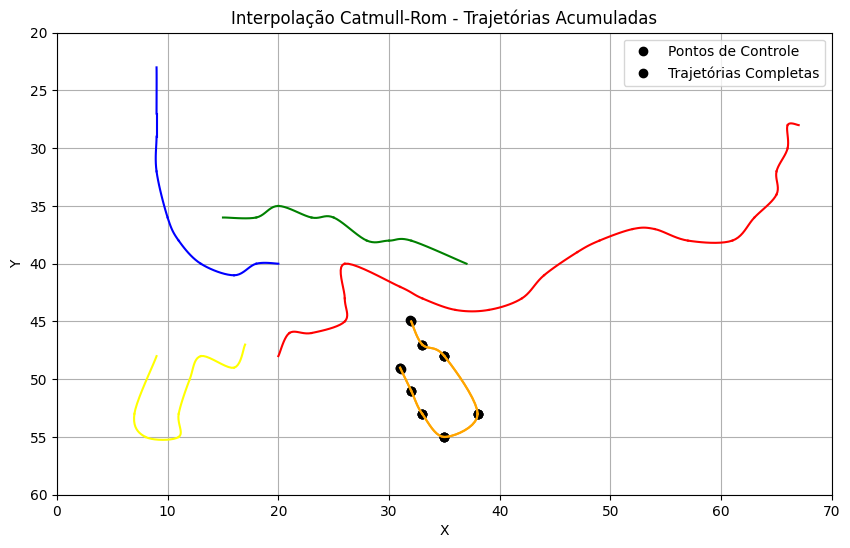

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Lista para armazenar todos os frames
all_frames = []

colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']

# Configuração da figura para plotagem dos gráficos
plt.figure(figsize=(10, 6))

# Lista para armazenar as coordenadas de todas as trajetórias completas
all_X = []
all_Y = []
all_control_x = []
all_control_y = []
all_colors = []
# Loop sobre cada chave em anotacao_novo_maiores_caminhos
for idx, (key, value) in enumerate(anotacao_novo_maiores_caminhos.items()):

    color = colors[idx % len(colors)]
    # Extraindo as coordenadas x e y
    coordenadas = anotacao_novo_maiores_caminhos[key]
    control_x = [coord[0] for coord in coordenadas]
    control_y = [coord[1] for coord in coordenadas]

    # Adicionando pontos fantasmas
    control_x.insert(0, control_x[0] - 0.1)
    control_x.append(control_x[-1] + 0.1)
    control_y.insert(0, control_y[0] - 0.1)
    control_y.append(control_y[-1] + 0.1)

    T = 1
    t = np.arange(0, 1.1, 0.1)
    N = len(control_x)

    interpolated_points = np.zeros((len(t), 2))
    X = np.zeros((len(t), N - 3))
    Y = np.zeros((len(t), N - 3))

    vx = np.zeros((N - 3, 4))
    vy = np.zeros((N - 3, 4))
    for i in range(N - 3):
        vx[i, :] = control_x[i:i + 4]
        vy[i, :] = control_y[i:i + 4]

    S = vx.shape

    # Construindo os dados de interpolação
    for i in range(S[0]):
        vx1 = vx[i, :]
        vy1 = vy[i, :]
        q_aux = catmull_rom_t(vx1, vy1, T)
        for j in range(len(t)):
            interpolated_points[j] = q_aux(t[j])
        X[:, i] = interpolated_points[:, 0]
        Y[:, i] = interpolated_points[:, 1]

    # Acumula os pontos de controle e trajetórias completas
    all_X.append(X)
    all_Y.append(Y)
    all_control_x.append(control_x)
    all_control_y.append(control_y)
    all_colors.append(color)

    # Criação da animação com pontos de controle primeiro e spline gradualmente
    for i in range(N - 3):
        plt.clf()  # Limpa a figura antes de plotar o próximo frame

        plt.plot(vx[:i + 1], vy[:i + 1], 'ko')  # Pontos de controle


        # Plota todas as trajetórias completas em suas cores correspondentes até o índice atual
        for past_X, past_Y, col in zip(all_X, all_Y, all_colors):
            plt.plot(past_X, past_Y, color=col)

        # Plota a spline parcial da interpolação atual em sua cor
        plt.plot(X[:, :i + 1], Y[:, :i + 1], color=color)

        plt.title('Interpolação Catmull-Rom - Trajetórias Acumuladas')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend(['Pontos de Controle', 'Trajetórias Completas'])
        plt.grid(True)
        plt.xlim(0, 70)
        plt.ylim(20, 60)
        plt.gca().invert_yaxis()

        # Salva o frame atual como uma imagem
        plt.draw()
        os.makedirs("frames", exist_ok=True)  # Cria o diretório 'frames' se ele não existir
        frame_path = f"./frames/frame_{key}_{i}.png"
        plt.savefig(frame_path)  # Salva o frame atual
        all_frames.append(Image.open(frame_path))  # Adiciona o frame como imagem na lista

# Cria o GIF a partir dos frames salvos
all_frames[0].save("interpolacao_catmull_rom_acumulado.gif", save_all=True, append_images=all_frames[1:], duration=300, loop=0)

print("GIF salvo como 'interpolacao_catmull_rom_acumulado.gif'")
plt.show()


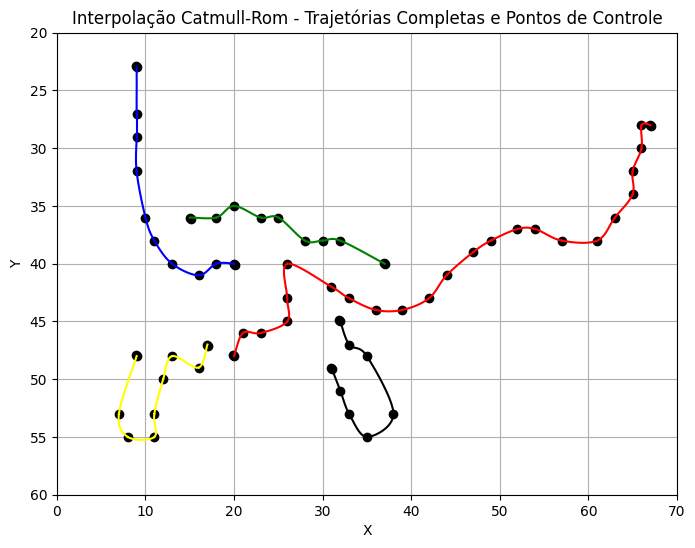

In [23]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['blue', 'red', 'green', 'yellow', 'black', 'black']

# Configuração da figura para plotagem dos gráficos
plt.figure(figsize=(8, 6))

# Lista para armazenar as coordenadas de todas as trajetórias completas
all_X = []
all_Y = []
all_control_x = []
all_control_y = []
all_colors = []

# Loop sobre cada chave em anotacao_novo_maiores_caminhos
for idx, (key, value) in enumerate(anotacao_novo_maiores_caminhos.items()):

    color = colors[idx % len(colors)]
    # Extraindo as coordenadas x e y
    coordenadas = anotacao_novo_maiores_caminhos[key]
    control_x = [coord[0] for coord in coordenadas]
    control_y = [coord[1] for coord in coordenadas]

    # Adicionando pontos fantasmas
    control_x.insert(0, control_x[0] - 0.1)
    control_x.append(control_x[-1] + 0.1)
    control_y.insert(0, control_y[0] - 0.1)
    control_y.append(control_y[-1] + 0.1)

    T = 1
    t = np.arange(0, 1.1, 0.1)
    N = len(control_x)

    interpolated_points = np.zeros((len(t), 2))
    X = np.zeros((len(t), N - 3))
    Y = np.zeros((len(t), N - 3))

    vx = np.zeros((N - 3, 4))
    vy = np.zeros((N - 3, 4))
    for i in range(N - 3):
        vx[i, :] = control_x[i:i + 4]
        vy[i, :] = control_y[i:i + 4]

    S = vx.shape

    # Construindo os dados de interpolação
    for i in range(S[0]):
        vx1 = vx[i, :]
        vy1 = vy[i, :]
        q_aux = catmull_rom_t(vx1, vy1, T)
        for j in range(len(t)):
            interpolated_points[j] = q_aux(t[j])
        X[:, i] = interpolated_points[:, 0]
        Y[:, i] = interpolated_points[:, 1]

    # Acumula os pontos de controle e trajetórias completas
    all_X.append(X)
    all_Y.append(Y)
    all_control_x.append(control_x)
    all_control_y.append(control_y)
    all_colors.append(color)

# Plotagem dos pontos de controle e trajetórias completas
for X, Y, control_x, control_y, color in zip(all_X, all_Y, all_control_x, all_control_y, all_colors):
    # Plotando os pontos de controle
    plt.plot(control_x, control_y, 'ko', label='Pontos de Controle')

    # Plotando a spline (interpolação) completa
    plt.plot(X, Y, color=color, label=f'Spline {color}')

# Definindo título, rótulos e legendas
plt.title('Interpolação Catmull-Rom - Trajetórias Completas e Pontos de Controle')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()
plt.grid(True)
plt.xlim(0, 70)
plt.ylim(20, 60)
plt.gca().invert_yaxis()

# Exibindo o gráfico
plt.show()
